In [26]:
import cv2
import numpy as np

def hex_to_bgr(hex_color):
    hex_color = hex_color.lstrip('#')
    bgr_color = tuple(int(hex_color[i:i+2], 16) for i in (4, 2, 0))
    return bgr_color

def bgr_to_hsv(bgr_color):
    bgr_array = np.uint8([[bgr_color]])
    hsv_array = cv2.cvtColor(bgr_array, cv2.COLOR_BGR2HSV)
    hsv_color = tuple(hsv_array[0][0])
    return hsv_color

def hex_to_hsv(hex_color):
    bgr_color = hex_to_bgr(hex_color)
    hsv_color = bgr_to_hsv(bgr_color)
    return hsv_color


box = ['#AB7245', '#8C5E37', '#E8BB72', '#FED080', '#EFBE75']

all_hex_colors = box
all_hsv_colors = [hex_to_hsv(hex_color) for hex_color in all_hex_colors]
all_hsv_colors

[(13, 152, 171),
 (14, 155, 140),
 (19, 130, 232),
 (19, 126, 254),
 (18, 130, 239)]

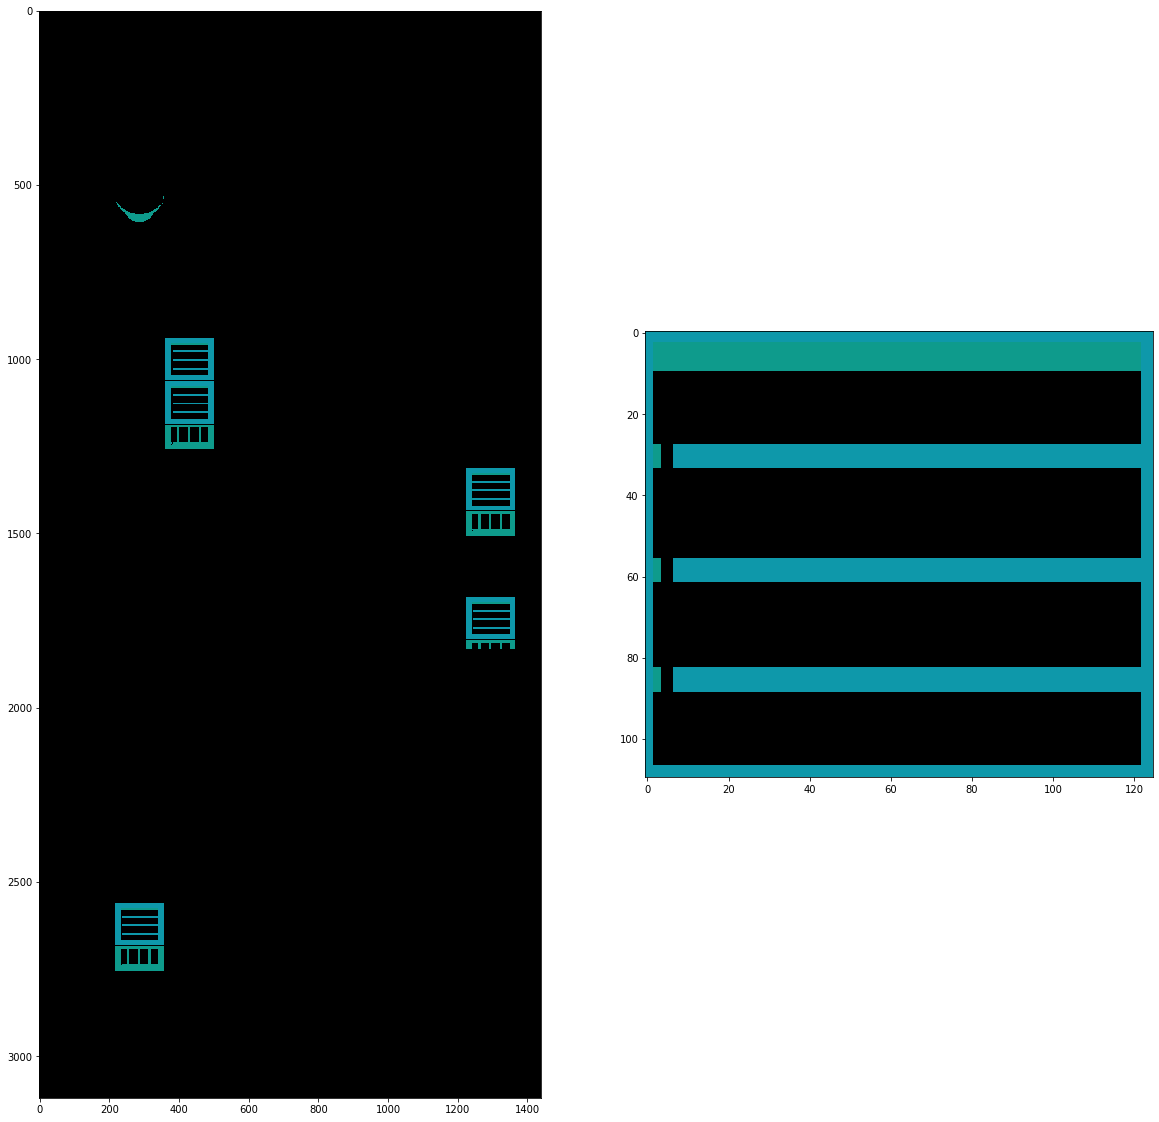

In [41]:
import matplotlib.pyplot as plt
import cv2
import numpy as np


def box_mask_image(image, tolerance=2):
    # box = ['#FFE18B', '#AB7245', '#8C5E37', '#E8BB72', '#FED080']
    colors = [
        # (22, 116, 255),
              (13, 152, 171),
              (14, 155, 140),
              # (19, 130, 232),
              # (19, 126, 254),
              # (18, 130, 239)
        ]
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    combined_mask = np.zeros_like(hsv_image[:, :, 0])

    for color in colors:
        lower_color = np.array(
            [max(color[0] - tolerance, 0), max(color[1] - tolerance, 0), max(color[2] - tolerance, 0)])
        upper_color = np.array([min(color[0] + tolerance, 180),
                                min(color[1] + tolerance, 255), min(color[2] + tolerance, 255)])

        mask = cv2.inRange(hsv_image, lower_color, upper_color)
        combined_mask = cv2.bitwise_or(combined_mask, mask)

    masked_image = cv2.bitwise_and(hsv_image, hsv_image, mask=combined_mask)
    return masked_image


im = cv2.imread('sc1.png')
masked_image = box_mask_image(im)
box_image = box_mask_image(cv2.imread('box.png'))

plt.figure(figsize=(20,20)) 
plt.subplot(1, 2, 1)
plt.imshow(masked_image)
plt.subplot(1, 2, 2)

plt.imshow(box_image)
plt.show()


## Matching box code

In [49]:
# matching function
from sklearn.cluster import DBSCAN


def find_all_templates(image, template, end=False, threshold=0.8):
    if len(template.shape[::-1]) == 2:
        template_width, template_height = template.shape[::-1]
    else:
        template_width, template_height = template.shape[::-1][1:]
    result = cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED)
    # looking at best position
    m = cv2.minMaxLoc(result)
    print(m)
    locations = np.where(result >= threshold)

    coordinates = []
    for pt in zip(*locations[::-1]):
        if end:
            x_center = pt[0] + template_width
            y_center = pt[1] + template_height
        else:
            x_center = pt[0] + template_width//2
            y_center = pt[1] + template_height//2
        coordinates.append((x_center, y_center))

    # cluster the points together
    # Use DBSCAN clustering to group close points
    coords = np.array(coordinates)
    if len(coords) == 0:
        return []
    dbscan = DBSCAN(eps=10, min_samples=5)
    dbscan.fit(coords)

    # Find the cluster centroids
    centroids = []
    for cluster_label in set(dbscan.labels_):
        if cluster_label != -1:  # Ignore the noise points (label -1)
            cluster_coords = coords[dbscan.labels_ == cluster_label]
            centroid = np.mean(cluster_coords, axis=0)
            centroids.append(centroid)

    centroids = [c.astype(int).tolist() for c in centroids]
    return centroids


def find_template(image, template, match_algo=cv2.TM_CCOEFF_NORMED, threshold=0.8):
    result = cv2.matchTemplate(image, template, match_algo)
    matches = cv2.minMaxLoc(result)
    print(matches)
    _, max_val, _, max_loc = matches

    if max_val > threshold:
        return max_loc
    return None


In [51]:
sc = cv2.imread('sc6-truth.png')
template = cv2.imread('box.png')

# plt.figure(figsize=(20,20)) 
# plt.subplot(1, 2, 1)
# plt.imshow(box_mask_image(sc))
# plt.subplot(1, 2, 2)
# plt.imshow(box_mask_image(template))
# plt.show()

algos = [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED, cv2.TM_CCORR, cv2.TM_CCORR_NORMED, cv2.TM_CCOEFF, cv2.TM_CCOEFF_NORMED]
algo_names = ['cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED', 'cv2.TM_CCORR', 'cv2.TM_CCORR_NORMED', 'cv2.TM_CCOEFF', 'cv2.TM_CCOEFF_NORMED']

for index, algo in enumerate(algos):
  coords = find_template(box_mask_image(sc), box_mask_image(template), match_algo=algo)
  print(algo_names[index], coords)
  print()

# for annotating points
# print(len(coords))
# print('coords', coords)
# sc = cv2.imread(dev.captured_sc_path)
# for c in coords:
#     cv2.circle(sc, (c[0], c[1]), radius=10,
#                 color=(0, 0, 255), thickness=-1)
# cv2.imwrite('./captured_screenshots_on_the_fly/annotated_screenshot.png', sc)

(1728350.0, 435515648.0, (738, 2143), (400, 2158))
cv2.TM_SQDIFF (400, 2158)

(0.008121540769934654, 1.0, (738, 2143), (0, 0))
cv2.TM_SQDIFF_NORMED (0, 0)

(-17.077777862548828, 211946432.0, (596, 2143), (738, 2143))
cv2.TM_CCORR (738, 2143)

(-5.783087431154854e-07, 0.995939314365387, (972, 760), (738, 2143))
cv2.TM_CCORR_NORMED (738, 2143)

(-55936684.0, 146886784.0, (400, 2158), (738, 2143))
cv2.TM_CCOEFF (738, 2143)

(-0.3525318205356598, 0.9941512942314148, (400, 2158), (738, 2143))
cv2.TM_CCOEFF_NORMED (738, 2143)



In [53]:
sc = cv2.imread('sc1.png')
template = cv2.imread('box2.png')

# plt.figure(figsize=(20,20)) 
# plt.subplot(1, 2, 1)
# plt.imshow(box_mask_image(sc))
# plt.subplot(1, 2, 2)
# plt.imshow(box_mask_image(template))
# plt.show()

algos = [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED, cv2.TM_CCORR, cv2.TM_CCORR_NORMED, cv2.TM_CCOEFF, cv2.TM_CCOEFF_NORMED]
algo_names = ['cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED', 'cv2.TM_CCORR', 'cv2.TM_CCORR_NORMED', 'cv2.TM_CCOEFF', 'cv2.TM_CCOEFF_NORMED']

for index, algo in enumerate(algos):
  coords = find_template(box_mask_image(sc), box_mask_image(template), match_algo=algo)
  print(algo_names[index], coords)
  print()

(3072680.0, 524136768.0, (370, 1072), (386, 1032))
cv2.TM_SQDIFF (386, 1032)

(0.009777876548469067, 1.0, (370, 1072), (0, 0))
cv2.TM_SQDIFF_NORMED (0, 0)

(-28.533334732055664, 312711872.0, (520, 1073), (370, 1072))
cv2.TM_CCORR (370, 1072)

(0.0, 0.9951111674308777, (0, 0), (370, 1072))
cv2.TM_CCORR_NORMED (370, 1072)

(-86839344.0, 173680768.0, (386, 1032), (370, 1072))
cv2.TM_CCOEFF (370, 1072)

(-0.4955902695655823, 0.9912320375442505, (386, 1032), (370, 1072))
cv2.TM_CCOEFF_NORMED (370, 1072)

